# Toast Case Study #

@author: Brian Shin

@date: 10.22.18

The purpose of this notebook is to conduct an open-ended analysis on the provided sample Toast Case Study.csv.

In [1]:
from datetime import datetime

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# read csv
df = pd.read_csv('Toast Case Study.csv', encoding='utf8')
print(df.shape)
df.head()

(225093, 12)


,Restaurant Id,Order Payment Id,Payment Type,Payment Status,Paid Timestamp yyyymmdd,Paiddate Timestamp,Order Amount,Tip Amount,Server Id,Digital Receipt,Refund Status,Deleted
0,1232000000000000,1232001000714108,CREDIT,CAPTURED,20161113,11/13/16 4:06:18 PM,42.75,0.0,1232000000000043,t,NONE,f
1,1232000000000000,1232001000714113,CREDIT,CAPTURED,20161113,11/13/16 4:08:59 PM,4.23,0.0,1232000000000043,t,NONE,f
2,1232000000000000,1232001000714121,CREDIT,CAPTURED,20161113,11/13/16 4:25:50 PM,18.01,1.0,1232000000000044,t,NONE,f
3,1232000000000000,1232001000714126,CREDIT,CAPTURED,20161113,11/13/16 4:26:24 PM,5.55,1.0,1232000000000044,t,NONE,f
4,1232000000000000,1232001000714131,CREDIT,CAPTURED,20161113,11/13/16 4:26:53 PM,8.51,0.0,1232000000000044,t,NONE,f


## 1. Order Distribution Across Restaurants ##

In [3]:
# group by restaurant ID and get counts of how many orders each one has along with percentage distribution
df_order_dist = df.groupby('Restaurant Id')['Order Payment Id'].count().reset_index()
df_order_dist['percentage'] = (100 * df_order_dist['Order Payment Id']) / df_order_dist['Order Payment Id'].sum()
df_order_dist

,Restaurant Id,Order Payment Id,percentage
0,1232000000000000,91902,40.828458
1,1233000000000000,70345,31.251527
2,2991000000000000,31719,14.091509
3,2998000000000000,16963,7.535996
4,3619000000000000,14164,6.292510


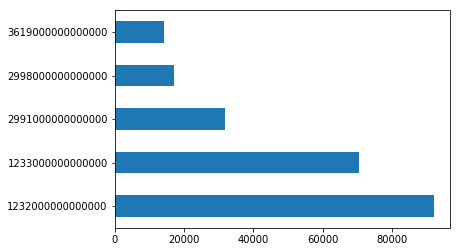

In [4]:
# histogram to visualize restaurants with most orders
df['Restaurant Id'].value_counts()[:20].plot(kind='barh')
plt.show()

### Notes###

- It appears Restaurant 1232000000000000 and 1233000000000000 do significantly better than the other 3.

- Next question to answer is why? Do they possibly do anything differently from the other branches (as far as we can tell from this dataset)? Have they existed longer than the other 3?

## 2. (Dollar) Order Amount Distribution Across Restaurants ##

In [5]:
# group by restaurant ID and get sums of total sales per each one along with percentage distribution
df_order_amount = df.groupby('Restaurant Id')['Order Amount'].sum().reset_index()
df_order_amount['percentage'] = (100 * df_order_amount['Order Amount']) / df_order_amount['Order Amount'].sum()
df_order_amount

,Restaurant Id,Order Amount,percentage
0,1232000000000000,927122.90,42.334685
1,1233000000000000,697593.39,31.853810
2,2991000000000000,302986.03,13.835079
3,2998000000000000,150464.22,6.870562
4,3619000000000000,111817.61,5.105864


In [6]:
# group by restaurant ID and get average dollar amount per order
df_order_avg = df.groupby('Restaurant Id')['Order Amount'].mean().reset_index()
df_order_avg

,Restaurant Id,Order Amount
0,1232000000000000,10.088169
1,1233000000000000,9.916744
2,2991000000000000,9.552194
3,2998000000000000,8.870142
4,3619000000000000,7.894494


### Notes ###

- Average order sizes of ~8 to ~10dollars make this restaurant seem like a fast food or bakery kind of place.

- 1232000000000000 and 1233000000000000 also appear to be doing significantly better, as expected from the orders they receive. Nothing unusual there.

- Was wondering if perhaps the average order sizes would explain why 1232E+12 and 1233E+12 do better. It appears that there is a slight difference in the average order amounts, but pretty marginal in real world application (~2dollar max difference in range).

- Also wanted to see if any restaurants had particularly large or small orders - could be useful data for vendor in how they strategize to capitalize on those differences. Although average order amounts are not super differentiated, knowing they have a pretty standard average order of 8~10dollars can be useful in knowing their customer's behavior. Maybe they can add a promotion to add an extra side to an individual meal or something like that to add some extra value per order.

## 3. Server Tips ##
- Do certain restaurants do better perhaps because of better service?
- Maybe the tips reveal something about the nature of the restaurant/business?

In [7]:
# create a column calculating tip percentages per ORDER
df_tip = df
df_tip['tip_perc'] = df_tip['Tip Amount'] / df_tip['Order Amount']
df_tip[['Restaurant Id', 'Tip Amount', 'Order Amount', 'tip_perc']].head(2)

,Restaurant Id,Tip Amount,Order Amount,tip_perc
0,1232000000000000,0.0,42.75,0.0
1,1232000000000000,0.0,4.23,0.0


In [8]:
# get average tip per order at each RESTAURANT
df_restaurant_tip = df_tip.groupby('Restaurant Id')['tip_perc'].mean().reset_index()
df_restaurant_tip.head(2)

,Restaurant Id,tip_perc
0,1232000000000000,0.038602
1,1233000000000000,0.035966


In [9]:
# get average tip per order for each SERVER
df_server_tip = df_tip.groupby('Server Id')['tip_perc'].mean().reset_index()
df_server_tip.head(2)

,Server Id,tip_perc
0,1232000000000027,0.013098
1,1232000000000029,0.000000


In [10]:
# join server IDs & their tip averages with the restaurant ID they work at along with the overall restaurant's average tip per order
# ex: for server[0] = 1232000000000027, his/her avg tip is 1.3%, while the restaurant's avg tip/order is 3.86%
df_tips = pd.merge(df_server_tip, df_tip, on='Server Id', how='inner')
df_tips = df_tips.groupby('Server Id')
df_tips = df_tips.head(1).reset_index()
df_tips = df_tips[['Server Id', 'tip_perc_x', 'Restaurant Id']]
df_rest_serv_tips = pd.merge(df_tips, df_restaurant_tip, on='Restaurant Id', how='left')
df_rest_serv_tips.columns = ['Server Id', 'server_avg_tip_perc', 'Restaurant Id', 'restaurant_avg_tip_perc']

print(df_rest_serv_tips.shape)
df_rest_serv_tips.head(2)

(29, 4)


,Server Id,server_avg_tip_perc,Restaurant Id,restaurant_avg_tip_perc
0,1232000000000027,0.013098,1232000000000000,0.038602
1,1232000000000029,0.000000,1232000000000000,0.038602


In [11]:
# get counts of how many orders every server has served
df_server_order_count = df.groupby('Server Id')['Order Payment Id'].count().reset_index()
df_server_order_count.head(2)

,Server Id,Order Payment Id
0,1232000000000027,11
1,1232000000000029,2


In [12]:
# join the quantity of orders each server has ever served to their tip details
df_tips_orders = pd.merge(df_rest_serv_tips, df_server_order_count, on='Server Id', how='left')
df_tips_orders.rename(columns={'Order Payment Id':'Server Orders Quantity'}, inplace=True)
df_tips_orders

,Server Id,server_avg_tip_perc,Restaurant Id,restaurant_avg_tip_perc,Server Orders Quantity
0,1232000000000027,0.013098,1232000000000000,0.038602,11
1,1232000000000029,0.000000,1232000000000000,0.038602,2
2,1232000000000040,0.094872,1232000000000000,0.038602,2
3,1232000000000043,0.039066,1232000000000000,0.038602,34334
4,1232000000000044,0.038328,1232000000000000,0.038602,57502
5,1232000000000048,0.020709,1232000000000000,0.038602,7
6,1232000000003189,0.000000,1232000000000000,0.038602,1
7,1232000000034405,0.000000,1232000000000000,0.038602,1
8,1232000000081621,0.033486,1232000000000000,0.038602,9
9,1232000000088925,0.319185,1232000000000000,0.038602,1


### Notes ###

- The generally low tips affirm my previous idea that this chain is a type of fast food restaurant, as the tips are pretty low, or non existent. If this was a sit-and-eat family restaurant, then we'd see more tips in the 15-20percent range.

- There also seems to be a decent number of servers that only worked just a handful of orders. This makes me wonder if this restaurant has a seasonal aspect to their sales (maybe they serve a lot of ice cream, and during the summer, they hire more part time servers. <-- something to look for when looking at date trends.

- Maybe some servers with higher avg tips compared to their branch's avg tip should be rewarded (like server 1233000000000329 who avgs 0.041953 copared to a branch avg of 0.035966).

## 4. Payment Status Across Restaurants and Servers##

In [13]:
# get distribution of Payment Statuses across all restaurants
print(df['Payment Status'].value_counts())
# get percentage distribution of Payment Statuses across all restaurants
df['Payment Status'].value_counts(normalize=True) 

# 98.5% CAPTURED is good
# to see for the remaining 1.5% of payment issues, dissect into DENIED, VOIDED, ERROR, ERROR_NETWORK to see
# if there's any way to improve to as close to 100%

CAPTURED               221642
DENIED                   1397
VOIDED                    905
AUTHORIZED                756
ERROR                     345
ERROR_NETWORK              45
CAPTURE_IN_PROGRESS         1
AUTHORIZED_AT_RISK          1
CANCELLED                   1
Name: Payment Status, dtype: int64


CAPTURED               0.984669
DENIED                 0.006206
VOIDED                 0.004021
AUTHORIZED             0.003359
ERROR                  0.001533
ERROR_NETWORK          0.000200
CAPTURE_IN_PROGRESS    0.000004
AUTHORIZED_AT_RISK     0.000004
CANCELLED              0.000004
Name: Payment Status, dtype: float64

In [14]:
# for payment status == ERROR, how many of those errors are caused by which servers (with restaurant ERROR totals to compare)
df_error = df[df['Payment Status'] == "ERROR"]
print(df_error.shape)

df_error_serv = df_error[['Server Id', 'Payment Status']].reset_index()
df_error_serv = df_error_serv.groupby('Server Id')['Payment Status'].count().reset_index()

df_error_rest = df_error[['Restaurant Id', 'Payment Status']].reset_index()
df_error_rest = df_error_rest.groupby('Restaurant Id')['Payment Status'].count().reset_index()

df_error_serv = pd.merge(df_error_serv, df_error, on='Server Id', how='inner')
df_error_rest = pd.merge(df_error_rest, df_error, on='Restaurant Id', how='inner')
df_error_serv_rest = pd.merge(df_error_serv, df_error_rest, on='Restaurant Id', how='inner')
df_error_serv_rest = df_error_serv_rest[['Server Id_x', 'Restaurant Id', 'Payment Status_y_x', 'Payment Status_x_x', 'Payment Status_x_y']]
df_error_serv_rest.columns = ['Server Id', 'Restaurant Id', 'Payment Status', 'Server ERROR Count', 'Restaurant ERROR Count']
df_error_serv_rest = df_error_serv_rest.groupby('Server Id').head(1).reset_index().drop(['index'], axis=1)
df_error_serv_rest['ERROR_perc_from_restaurant'] = df_error_serv_rest['Server ERROR Count'] / df_error_serv_rest['Restaurant ERROR Count']
df_server_counts = df.groupby('Server Id')['Order Payment Id'].count().reset_index()
df_error_serv_rest_joined = pd.merge(df_error_serv_rest, df_server_counts, on='Server Id', how='inner')
df_error_serv_rest_joined['ERROR_perc_from_server'] = df_error_serv_rest_joined['Server ERROR Count'] / df_error_serv_rest_joined['Order Payment Id']
df_error_serv_rest_joined.rename(columns={'Order Payment Id':'Server Orders Quantity'}, inplace=True)
df_error_serv_rest_joined


(345, 13)


,Server Id,Restaurant Id,Payment Status,Server ERROR Count,Restaurant ERROR Count,ERROR_perc_from_restaurant,Server Orders Quantity,ERROR_perc_from_server
0,1232000000000043,1232000000000000,ERROR,74,180,0.411111,34334,0.002155
1,1232000000000044,1232000000000000,ERROR,106,180,0.588889,57502,0.001843
2,1233000000000034,1233000000000000,ERROR,44,127,0.346457,27776,0.001584
3,1233000000000035,1233000000000000,ERROR,83,127,0.653543,42511,0.001952
4,2991000000000038,2991000000000000,ERROR,4,14,0.285714,10324,0.000387
5,2991000000000039,2991000000000000,ERROR,10,14,0.714286,21394,0.000467
6,2998000000000061,2998000000000000,ERROR,4,11,0.363636,11067,0.000361
7,2998000000000068,2998000000000000,ERROR,7,11,0.636364,5883,0.001190
8,3619000000000072,3619000000000000,ERROR,13,13,1.000000,14141,0.000919


In [15]:
# for payment status == ERROR, how manny of those errors are caused by which servers (with restaurant ERROR totals to compare)
# maybe also, shows if a certain restaurant needs extra training or IT support to fix errors
df_error_nw = df[df['Payment Status'] == "ERROR_NETWORK"]
print(df_error_nw.shape)

df_error_nw_serv = df_error_nw[['Server Id', 'Payment Status']].reset_index()
df_error_nw_serv = df_error_nw_serv.groupby('Server Id')['Payment Status'].count().reset_index()

df_error_nw_rest = df_error_nw[['Restaurant Id', 'Payment Status']].reset_index()
df_error_nw_rest = df_error_nw_rest.groupby('Restaurant Id')['Payment Status'].count().reset_index()

df_error_nw_serv = pd.merge(df_error_nw_serv, df_error_nw, on='Server Id', how='inner')
df_error_nw_rest = pd.merge(df_error_nw_rest, df_error_nw, on='Restaurant Id', how='inner')
df_error_nw_serv_rest = pd.merge(df_error_nw_serv, df_error_nw_rest, on='Restaurant Id', how='inner')
df_error_nw_serv_rest = df_error_nw_serv_rest[['Server Id_x', 'Restaurant Id', 'Payment Status_y_x', 'Payment Status_x_x', 'Payment Status_x_y']]
df_error_nw_serv_rest.columns = ['Server Id', 'Restaurant Id', 'Payment Status', 'Server ERROR_NETWORK Count', 'Restaurant ERROR_NETWORK Count']
df_error_nw_serv_rest = df_error_nw_serv_rest.groupby('Server Id').head(1).reset_index().drop(['index'], axis=1)
df_error_nw_serv_rest['ERROR_NETWORK_perc'] = df_error_nw_serv_rest['Server ERROR_NETWORK Count'] / df_error_nw_serv_rest['Restaurant ERROR_NETWORK Count']
df_server_counts = df.groupby('Server Id')['Order Payment Id'].count().reset_index()
df_error_nw_serv_rest_joined = pd.merge(df_error_nw_serv_rest, df_server_counts, on='Server Id', how='inner')
df_error_nw_serv_rest_joined['ERROR_NETWORK_perc_from_server'] = df_error_nw_serv_rest_joined['Server ERROR_NETWORK Count'] / df_error_nw_serv_rest_joined['Order Payment Id']
df_error_nw_serv_rest_joined.rename(columns={'Order Payment Id':'Server Orders Quantity'}, inplace=True)
df_error_nw_serv_rest_joined



(45, 13)


,Server Id,Restaurant Id,Payment Status,Server ERROR_NETWORK Count,Restaurant ERROR_NETWORK Count,ERROR_NETWORK_perc,Server Orders Quantity,ERROR_NETWORK_perc_from_server
0,1232000000000043,1232000000000000,ERROR_NETWORK,14,21,0.666667,34334,0.000408
1,1232000000000044,1232000000000000,ERROR_NETWORK,7,21,0.333333,57502,0.000122
2,1233000000000034,1233000000000000,ERROR_NETWORK,7,18,0.388889,27776,0.000252
3,1233000000000035,1233000000000000,ERROR_NETWORK,11,18,0.611111,42511,0.000259
4,3619000000000072,3619000000000000,ERROR_NETWORK,6,6,1.000000,14141,0.000424


In [16]:
# for payment status == VOIDED, how manny of those are caused by which servers (with restaurant VOIDED totals to compare)
# what does VOIDED mean?
df_voided = df[df['Payment Status'] == "VOIDED"]
print(df_voided.shape)

df_voided_serv = df_voided[['Server Id', 'Payment Status']].reset_index()
df_voided_serv = df_voided_serv.groupby('Server Id')['Payment Status'].count().reset_index()

df_voided_rest = df_voided[['Restaurant Id', 'Payment Status']].reset_index()
df_voided_rest = df_voided_rest.groupby('Restaurant Id')['Payment Status'].count().reset_index()

df_voided_serv = pd.merge(df_voided_serv, df_voided, on='Server Id', how='inner')
df_voided_rest = pd.merge(df_voided_rest, df_voided, on='Restaurant Id', how='inner')
df_voided_serv_rest = pd.merge(df_voided_serv, df_voided_rest, on='Restaurant Id', how='inner')
df_voided_serv_rest = df_voided_serv_rest[['Server Id_x', 'Restaurant Id', 'Payment Status_y_x', 'Payment Status_x_x', 'Payment Status_x_y']]
df_voided_serv_rest.columns = ['Server Id', 'Restaurant Id', 'Payment Status', 'Server VOIDED Count', 'Restaurant VOIDED Count']
df_voided_serv_rest = df_voided_serv_rest.groupby('Server Id').head(1).reset_index().drop(['index'], axis=1)
df_voided_serv_rest['VOIDED_perc'] = df_voided_serv_rest['Server VOIDED Count'] / df_voided_serv_rest['Restaurant VOIDED Count']
df_server_counts = df.groupby('Server Id')['Order Payment Id'].count().reset_index()
df_voided_serv_rest_joined = pd.merge(df_voided_serv_rest, df_server_counts, on='Server Id', how='inner')
df_voided_serv_rest_joined['VOIDED_perc_from_server'] = df_voided_serv_rest_joined['Server VOIDED Count'] / df_voided_serv_rest_joined['Order Payment Id']
df_voided_serv_rest_joined.rename(columns={'Order Payment Id':'Server Orders Quantity'}, inplace=True)
df_voided_serv_rest_joined



(905, 13)


,Server Id,Restaurant Id,Payment Status,Server VOIDED Count,Restaurant VOIDED Count,VOIDED_perc,Server Orders Quantity,VOIDED_perc_from_server
0,1232000000000043,1232000000000000,VOIDED,50,158,0.316456,34334,0.001456
1,1232000000000044,1232000000000000,VOIDED,106,158,0.670886,57502,0.001843
2,1232000000095677,1232000000000000,VOIDED,2,158,0.012658,32,0.062500
3,1233000000000028,1233000000000000,VOIDED,1,357,0.002801,7,0.142857
4,1233000000000034,1233000000000000,VOIDED,130,357,0.364146,27776,0.004680
5,1233000000000035,1233000000000000,VOIDED,226,357,0.633053,42511,0.005316
6,2991000000000038,2991000000000000,VOIDED,49,156,0.314103,10324,0.004746
7,2991000000000039,2991000000000000,VOIDED,107,156,0.685897,21394,0.005001
8,2998000000000061,2998000000000000,VOIDED,144,185,0.778378,11067,0.013012
9,2998000000000068,2998000000000000,VOIDED,41,185,0.221622,5883,0.006969


In [17]:
# for payment status == DENIED, how many of those are caused by which servers (with restaurant DENIED totals to compare)
# what does DENIED mean?
df_denied = df[df['Payment Status'] == "DENIED"]
print(df_denied.shape)

df_denied_serv = df_denied[['Server Id', 'Payment Status']].reset_index()
df_denied_serv = df_denied_serv.groupby('Server Id')['Payment Status'].count().reset_index()

df_denied_rest = df_denied[['Restaurant Id', 'Payment Status']].reset_index()
df_denied_rest = df_denied_rest.groupby('Restaurant Id')['Payment Status'].count().reset_index()

df_denied_serv = pd.merge(df_denied_serv, df_denied, on='Server Id', how='inner')
df_denied_rest = pd.merge(df_denied_rest, df_denied, on='Restaurant Id', how='inner')
df_denied_serv_rest = pd.merge(df_denied_serv, df_denied_rest, on='Restaurant Id', how='inner')
df_denied_serv_rest = df_denied_serv_rest[['Server Id_x', 'Restaurant Id', 'Payment Status_y_x', 'Payment Status_x_x', 'Payment Status_x_y']]
df_denied_serv_rest.columns = ['Server Id', 'Restaurant Id', 'Payment Status', 'Server DENIED Count', 'Restaurant DENIED Count']
df_denied_serv_rest = df_denied_serv_rest.groupby('Server Id').head(1).reset_index().drop(['index'], axis=1)
df_denied_serv_rest['DENIED_perc'] = df_denied_serv_rest['Server DENIED Count'] / df_denied_serv_rest['Restaurant DENIED Count']
df_server_counts = df.groupby('Server Id')['Order Payment Id'].count().reset_index()
df_denied_serv_rest_joined = pd.merge(df_denied_serv_rest, df_server_counts, on='Server Id', how='inner')
df_denied_serv_rest_joined['DENIED_perc_from_server'] = df_denied_serv_rest_joined['Server DENIED Count'] / df_denied_serv_rest_joined['Order Payment Id']
df_denied_serv_rest_joined.rename(columns={'Order Payment Id':'Server Orders Quantity'}, inplace=True)

df_denied_serv_rest_joined



(1397, 13)


,Server Id,Restaurant Id,Payment Status,Server DENIED Count,Restaurant DENIED Count,DENIED_perc,Server Orders Quantity,DENIED_perc_from_server
0,1232000000000029,1232000000000000,DENIED,1,617,0.001621,2,0.500000
1,1232000000000043,1232000000000000,DENIED,270,617,0.437601,34334,0.007864
2,1232000000000044,1232000000000000,DENIED,346,617,0.560778,57502,0.006017
3,1233000000000028,1233000000000000,DENIED,1,441,0.002268,7,0.142857
4,1233000000000034,1233000000000000,DENIED,193,441,0.437642,27776,0.006948
5,1233000000000035,1233000000000000,DENIED,247,441,0.560091,42511,0.005810
6,2991000000000038,2991000000000000,DENIED,52,113,0.460177,10324,0.005037
7,2991000000000039,2991000000000000,DENIED,61,113,0.539823,21394,0.002851
8,2998000000000061,2998000000000000,DENIED,58,85,0.682353,11067,0.005241
9,2998000000000068,2998000000000000,DENIED,27,85,0.317647,5883,0.004589


### Notes ###
- I initially wanted to dig into they payment statuses because as a business the successful payments deserves the extra attention. Even if it's to ensure that it's at an acceptable rate. Any failed payments after a given service/product is lost money.

- 98.5% CAPTURED is good, only 1.5% of non-captures, but if the restaurant wants to see if there's any way to improve to as close to 100%, then they can look into filling in the gaps- specifically where there were ERROR, ERROR_NETWORK, VOIDED, and DENIED payments (maybe for ERROR/ERROR_NETWORK have to do with retraining employees or fixing IT problems that cause both human and machine errors).

## 5. Date Trends ##

In [18]:
# to ignore warning message of future deprecation
pd.options.mode.chained_assignment = None

# turn dates into datetime data type
df_dates = df[['Restaurant Id', 'Paid Timestamp yyyymmdd']]
df_dates['Paid Timestamp yyyymmdd'] = df_dates["Paid Timestamp yyyymmdd"].apply(lambda x: str(x)[:4]+'-'+str(x)[4:6]+'-'+str(x)[6:])
df_dates['Paid Timestamp yyyymmdd'] = pd.to_datetime(df_dates['Paid Timestamp yyyymmdd'])
df_dates['Paid Timestamp yyyymmdd'] = df_dates['Paid Timestamp yyyymmdd'].apply(lambda x: x.to_datetime())   

df_dates.head(2)

,Restaurant Id,Paid Timestamp yyyymmdd
0,1232000000000000,2016-11-13
1,1232000000000000,2016-11-13


In [19]:
# pivot to get counts of orders placed grouped by RESTAURANT, then YEARS ONLY
df_dates_yr = df_dates
df_dates_yr['date_bucket_yyyy'] = df_dates_yr['Paid Timestamp yyyymmdd'].map(lambda x: x.year)

df_dates_pivot_yr = pd.pivot_table(df_dates_yr, index=['Restaurant Id', 'date_bucket_yyyy'], aggfunc='count')
df_dates_pivot_yr.rename(columns={'Paid Timestamp yyyymmdd':'orders_placed_count'}, inplace=True)
# print output of distribution in percentages
print(df_dates_yr['date_bucket_yyyy'].value_counts(normalize=True))
df_dates_pivot_yr

2016    0.665027
2015    0.334973
Name: date_bucket_yyyy, dtype: float64


orders_placed_count
Restaurant Id    date_bucket_yyyy                     
1232000000000000 2015                            41608
                 2016                            50294
1233000000000000 2015                            33792
                 2016                            36553
2991000000000000 2016                            31719
2998000000000000 2016                            16963
3619000000000000 2016                            14164

In [20]:
# pivot to get counts of orders placed grouped by RESTAURANT, then MONTHS ONLY
df_dates_mo = df_dates[['Restaurant Id', 'Paid Timestamp yyyymmdd']]
df_dates_mo['date_bucket_mm'] = df_dates_mo['Paid Timestamp yyyymmdd'].map(lambda x: x.month)
df_dates_pivot_mo = pd.pivot_table(df_dates_mo, index=['Restaurant Id','date_bucket_mm'], aggfunc='count')
df_dates_pivot_mo.rename(columns={'Paid Timestamp yyyymmdd':'orders_placed_count'}, inplace=True)
# print output of distribution in percentages
print(df_dates_mo['date_bucket_mm'].value_counts(normalize=True))
df_dates_pivot_mo

8     0.159849
7     0.159196
9     0.141728
6     0.125917
5     0.106289
10    0.083588
4     0.070300
11    0.056972
3     0.031036
1     0.022835
2     0.022146
12    0.020143
Name: date_bucket_mm, dtype: float64


orders_placed_count
Restaurant Id    date_bucket_mm                     
1232000000000000 1                              3288
                 2                              3172
                 3                              4145
                 4                              9372
                 5                             11429
                 6                             10840
                 7                             12133
                 8                             11891
                 9                              8962
                 10                             7478
                 11                             6385
                 12                             2807
1233000000000000 1                              1852
                 2                              1813
                 3                              2841
                 4                              6452
                 5                              9801
                 6                              9083
                 7                             10625
                 8                              9531
                 9                              7539
                 10                             5135
                 11                             3946
                 12                             1727
2991000000000000 5                               916
                 6                              6499
                 7                              7188
                 8                              6631
                 9                              4671
                 10                             3321
                 11                             2493
2998000000000000 5                              1779
                 6                              1921
                 7                              2098
                 8                              3564
                 9                              7203
                 10                              398
3619000000000000 7                              3790
                 8                              4364
                 9                              3527
                 10                             2483

In [21]:
# pivot to get counts of orders placed grouped by RESTAURANTS, then YEARS AND MONTHS
df_dates_ym = df_dates[['Restaurant Id', 'Paid Timestamp yyyymmdd', 'date_bucket_yyyy']]
df_dates_ym['date_bucket_yyyymm'] = df_dates_ym['Paid Timestamp yyyymmdd'].map(lambda x: x.month)
df_dates_pivot_ym = pd.pivot_table(df_dates_ym, index=['Restaurant Id', 'date_bucket_yyyy', 'date_bucket_yyyymm'], aggfunc='count')
df_dates_pivot_ym.rename(columns={'Paid Timestamp yyyymmdd':'orders_placed_count'}, inplace=True)
# print output of distribution in percentages
print(df_dates_ym.groupby('date_bucket_yyyy')['date_bucket_yyyymm'].value_counts(normalize=True))
df_dates_pivot_ym


date_bucket_yyyy  date_bucket_yyyymm
2015              5                     0.149987
                  7                     0.148700
                  8                     0.142825
                  6                     0.128767
                  9                     0.111353
                  4                     0.097573
                  10                    0.084058
                  11                    0.073568
                  12                    0.060133
                  3                     0.003024
                  1                     0.000013
2016              8                     0.168425
                  7                     0.164483
                  9                     0.157028
                  6                     0.124481
                  5                     0.084279
                  10                    0.083351
                  4                     0.056562
                  11                    0.048613
                  3             

orders_placed_count
Restaurant Id    date_bucket_yyyy date_bucket_yyyymm                     
1232000000000000 2015             3                                   156
                                  4                                  4355
                                  5                                  5840
                                  6                                  5210
                                  7                                  5947
                                  8                                  5841
                                  9                                  4395
                                  10                                 3662
                                  11                                 3395
                                  12                                 2807
                 2016             1                                  3288
                                  2                                  3172
                                  3                                  3989
                                  4                                  5017
                                  5                                  5589
                                  6                                  5630
                                  7                                  6186
                                  8                                  6050
                                  9                                  4567
                                  10                                 3816
                                  11                                 2990
1233000000000000 2015             1                                     1
                                  3                                    72
                                  4                                  3002
                                  5                                  5469
                                  6                                  4499
                                  7                                  5265
                                  8                                  4928
                                  9                                  4001
                                  10                                 2676
                                  11                                 2152
                                  12                                 1727
                 2016             1                                  1851
                                  2                                  1813
                                  3                                  2769
                                  4                                  3450
                                  5                                  4332
                                  6                                  4584
                                  7                                  5360
                                  8                                  4603
                                  9                                  3538
                                  10                                 2459
                                  11                                 1794
2991000000000000 2016             5                                   916
                                  6                                  6499
                                  7                                  7188
                                  8                                  6631
                                  9                                  4671
                                  10                                 3321
                                  11                                 2493
2998000000000000 2016             5                                  1779
                                  6                                  1921
                                  7                       

In [22]:
# turn dates into datetime data type but include Server ID to pivot on instead of Restaurant ID
pd.options.mode.chained_assignment = None
df_serv_dates = df[['Server Id', 'Paid Timestamp yyyymmdd']]
df_serv_dates['Paid Timestamp yyyymmdd'] = df_serv_dates["Paid Timestamp yyyymmdd"].apply(lambda x: str(x)[:4]+'-'+str(x)[4:6]+'-'+str(x)[6:])
df_serv_dates['Paid Timestamp yyyymmdd'] = pd.to_datetime(df_serv_dates['Paid Timestamp yyyymmdd'])
df_serv_dates['Paid Timestamp yyyymmdd'] = df_serv_dates['Paid Timestamp yyyymmdd'].apply(lambda x: x.to_datetime()) 

# pivot to get counts of orders placed grouped by SERVER, in YEARS AND MONTHS, filtered by servers who served UNDER 50 ORDERS
df_serv_dates['date_bucket_yyyy'] = df_serv_dates['Paid Timestamp yyyymmdd'].map(lambda x: x.year)
df_serv_dates_ym = df_serv_dates[['Server Id', 'Paid Timestamp yyyymmdd', 'date_bucket_yyyy']]
df_serv_dates_ym = pd.merge(df_serv_dates_ym, df_server_order_count[df_server_order_count['Order Payment Id'] < 50], on='Server Id', how='inner')
df_serv_dates_ym['date_bucket_yyyymm'] = df_serv_dates_ym['Paid Timestamp yyyymmdd'].map(lambda x: x.month)
df_serv_dates_pivot_ym = pd.pivot_table(df_serv_dates_ym, index=['Server Id', 'date_bucket_yyyy', 'date_bucket_yyyymm'], aggfunc='count')
df_serv_dates_pivot_ym.rename(columns={'Paid Timestamp yyyymmdd':'orders_placed_count'}, inplace=True)
df_serv_dates_pivot_ym = df_serv_dates_pivot_ym.drop('Order Payment Id',axis=1)
df_serv_dates_pivot_ym

orders_placed_count
Server Id        date_bucket_yyyy date_bucket_yyyymm                     
1232000000000027 2015             7                                    11
1232000000000029 2015             3                                     2
1232000000000040 2016             11                                    2
1232000000000048 2015             4                                     1
                                  8                                     2
                                  10                                    3
                 2016             2                                     1
1232000000003189 2015             5                                     1
1232000000034405 2016             5                                     1
1232000000081621 2016             5                                     1
                                  6                                     4
                                  7                                     4
1232000000088925 2016             7                                     1
1232000000095677 2016             6                                    32
1233000000000028 2015             3                                     1
                                  8                                     1
                                  9                                     3
                                  10                                    2
1233000000000031 2015             5                                     1
                 2016             1                                     1
1233000000000032 2016             2                                     5
1233000000000329 2015             5                                    34
1233000000023631 2016             6                                    10
2991000000000043 2016             6                                     1
2998000000000025 2016             5                                     2
2998000000000034 2016             5                                     1
2998000000000048 2016             5                                     4
2998000000002598 2016             5                                     1
                                  6                                     5
3619000000000063 2016             7                                    13
                                  8                                    10

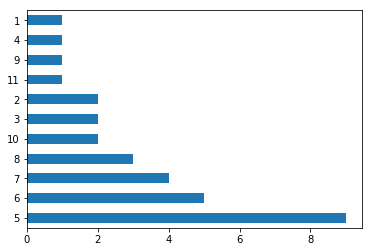

In [24]:
# histogram to visualize MONTH that SERVERS with UNDER 50 ORDERS worked the most
df_temp_hires = df_serv_dates_pivot_ym.reset_index()
df_temp_hires = df_temp_hires[['Server Id', 'date_bucket_yyyymm', 'orders_placed_count']]
df_temp_hires.head(2)
df_temp_hires['date_bucket_yyyymm'].value_counts()[:20].plot(kind='barh') #or barh for horizontal
plt.show()

### Notes ###

- There was a solid growth period between 2015 and 2016, with their sales almost doubled (2016=0.665027, 2015=0.334973 of sales). in 1232E+12 and 1233E+12, they had moderate increases between the 2 years, but most of the total increase in sales came from opening up the other 3 branches. 

- When pivoting on month, it appears that the summer months are far busier, with 58.7% of their total sales coming from the summer months (JUN-SEPT). On the other end, their least busy months take place during the winter (DEC-MAR), making up 9.6% of their total sales. Is this an ice cream store?

- Also dug more into the previous hypothesis that this business had a seasonal aspect, and I tested if there'd be any indication of extra seasonal hiring of perhaps part-time servers. Looking at all servers with less than 50 orders recorded, and there is a decent amount that this applies to.

- Out of 20 of the servers who had less than 50 orders to their name, 18 of them worked summer months or were hiring right before the summer (MAY). 

## Takeaways ##

#### General Trends ####
- Sales in 2016 doubled 2015, with 3 new branches openining up in 2016.

- More than half of their sales happen during the summer, along with the majority of their temporary hires.



#### Anything Interesting or Surprising ####
- The contrast between sales in the summer months vs the winter months is pretty wild. The winter months make almost zero money, while the summer months are busy.

- This could be useful to the restaurants in terms of inventory and personnel management dedicated to these slow months. This is also true for the summer months where it is extremely busy. They can better prepare for these peak times with more personnel, inventroy scheduling, extended business hours, coupons/deals/promotions, etc.


#### High or Low Value Customer to Toast? ####
- I would say high, as they opened 3 new branches in 2016, which doubled their sales from the previous year. They have a steady growth trajectory, and opening new branches seems to be the biggest indicator of their sales growth. This means more services Toast can provide with each new branch they open.

- With more branches opening in 2016 (and possibly in the future), it will be harder for the business to reconcile their operations. Business with Toast will become more and more valuable to them with possible new contracts.


#### What Additional Information Would You Like to See? ####
- Locations of restaurants (either zip, city, etc).

- Whether customers decided to eat in or take out (getting counts of both could be useful to the restaurant in maybe opening a drive-thru or mobile orders/courier services, etc).

- What the customers ordered (see which menu items are popular vs not).


#### Any Guesses About What Type of Restaurant This Is? ####
- Maybe fast food or bakery type with the average dollar amount per order of 7-10 bucks and low avg tips.

- Seasonal market with periodic employee hiring and small order costs.

- Best guess is ice cream place (or some other cold food). Maybe open in some places where it's summer year round so it's always peak time.